# F) Supervised Learning 💻🦾⚙
1) Define target: binary pass/fail or 3-class risk.

2) Train at least three algorithms (e.g., Logistic Regression, Decision Tree/Random Forest, SVM).

3) Use hold-out and 5-fold CV; perform basic hyperparameter tuning.

4) Report full metrics (Accuracy, Precision, Recall, F1; ROC-AUC for binary).

5) Interpret model (feature importances or coefficients).

In [ ]:
# Imports & Config

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

import joblib
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

# ---------------- Load config ----------------
with open("../artifacts/active_dataset.json", "r") as f:
    config = json.load(f)

active_dataset_name = config["active_dataset"]
processed_path = config["processed_path"]

# Load processed dataset (same one used in C/D/E)
df = pd.read_csv(processed_path)

print(f"Loaded processed dataset: {active_dataset_name}")
print("Shape:", df.shape)
display(df.head())

# Output folders
fig_dir = "../artifacts/figures"
os.makedirs(fig_dir, exist_ok=True)

results_dir = "../artifacts/results"
os.makedirs(results_dir, exist_ok=True)

models_dir = "../artifacts/models"
os.makedirs(models_dir, exist_ok=True)


print("✅ Config & data loaded successfully")


Loaded processed dataset: merged
Shape: (1044, 42)


,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,3,4,1,1,3,6,5,6,6
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,5,3,3,1,1,3,4,5,5,6
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4,3,2,2,3,3,10,7,8,10
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,3,2,2,1,1,5,2,15,14,15
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4,3,2,1,2,5,4,6,10,10


✅ Config & data loaded successfully


In [ ]:
# Define target(s) + basic checks

# 1) Binary target: pass/fail based on G3
df["pass"] = (df["G3"] >= 10).astype(int)

# 2) Optional 3-class risk
def risk_bucket(g3):
    if g3 < 10: 
        return "low"
    elif g3 < 15: 
        return "medium"
    else: 
        return "high"

df["risk_3class"] = df["G3"].apply(risk_bucket)

# Choose target mode: "binary" or "multiclass"
TARGET_MODE = "binary"   
TARGET_COL = "pass" if TARGET_MODE == "binary" else "risk_3class"

print(f"Target mode: {TARGET_MODE}  |  Target column: {TARGET_COL}")

# Show target distribution
print("\nTarget distribution:")
print(df[TARGET_COL].value_counts(dropna=False))
print("\nTarget distribution (ratio):")
print(df[TARGET_COL].value_counts(normalize=True).round(3))


Target mode: binary  |  Target column: pass

Target distribution:
pass
1    814
0    230
Name: count, dtype: int64

Target distribution (ratio):
pass
1    0.78
0    0.22
Name: proportion, dtype: float64


In [3]:
# Build leakage variants (with/without G1,G2)

# Columns to exclude from X (targets & known leakage)
always_exclude = {"G3", "pass", "risk_3class"}  # never use in features

# Get numeric columns only (models need numeric; one-hot are numeric too)
numeric_cols = df.select_dtypes(include=[np.number, np.bool_]).columns.tolist()

# Make safe exclusion
available_cols = [c for c in numeric_cols if c not in always_exclude]

# Variant A: with G1,G2 (if present)
with_cols = available_cols.copy()
# Variant B: without G1,G2 (if present)
without_cols = [c for c in available_cols if c not in ["G1", "G2"]]

# Ensure lists are not empty
print(f"\nVariant A (with_G1G2) feature count: {len(with_cols)}")
print(f"Variant B (no_G1G2) feature count : {len(without_cols)}")

# Keep as dict for looped training later
feature_variants = {
    "with_G1G2": with_cols,
    "no_G1G2": without_cols
}

# Quick peek
for k, v in feature_variants.items():
    print(f"\n{k}: sample of features -> {v[:10]} ... (total {len(v)})")



Variant A (with_G1G2) feature count: 41
Variant B (no_G1G2) feature count : 39

with_G1G2: sample of features -> ['school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health'] ... (total 41)

no_G1G2: sample of features -> ['school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health'] ... (total 39)


In [4]:
# Helper functions (split/scale, metrics, plots)

RANDOM_STATE = 42
CV_FOLDS = 5

def split_and_scale(df, features, target_col):
    X = df[features].copy()
    y = df[target_col].copy()
    stratify = y if TARGET_MODE == "binary" else None  # multiclass sometimes has small groups

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if TARGET_MODE=="binary" else None
    )
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, X_train_s, X_test_s, scaler

def eval_binary(y_true, y_pred, y_proba=None):
    out = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        out["ROC-AUC"] = roc_auc_score(y_true, y_proba)
    return out

def eval_multiclass(y_true, y_pred, proba=None):
    out = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
    }
    # macro ROC-AUC (optional)
    try:
        if proba is not None:
            out["ROC-AUC_macro"] = roc_auc_score(pd.get_dummies(y_true), proba, multi_class="ovr")
    except Exception:
        pass
    return out

def plot_and_save_confusion_matrix(y_true, y_pred, title, out_path):
    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=True)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(out_path, dpi=130)
    plt.show()

def plot_and_save_roc(estimator, X_test_s, y_test, title, out_path):
    if TARGET_MODE == "binary":
        RocCurveDisplay.from_estimator(estimator, X_test_s, y_test)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(out_path, dpi=130)
        plt.show()
    else:
        # For multiclass, skip ROC plot here or implement one-vs-rest per class (optional)
        pass



================ Variant: with_G1G2 ================


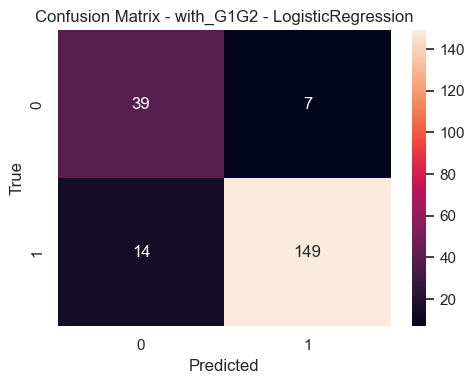

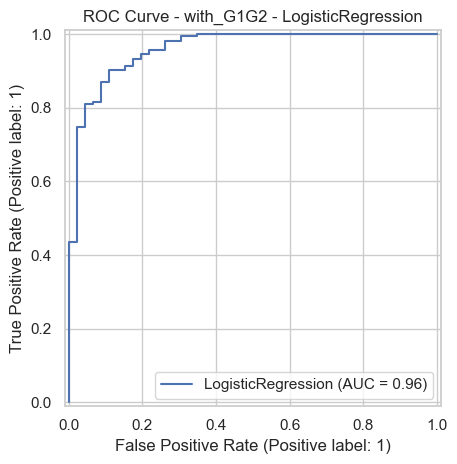

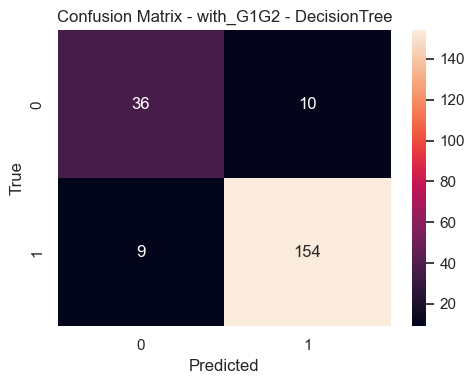

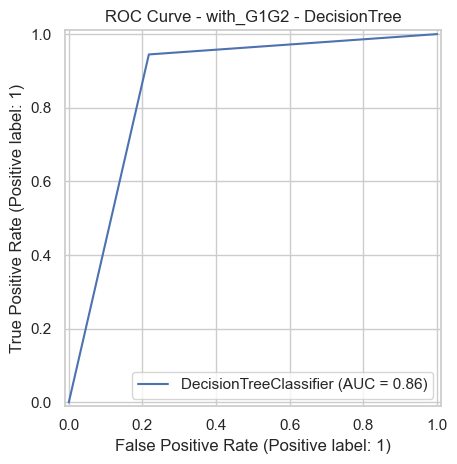

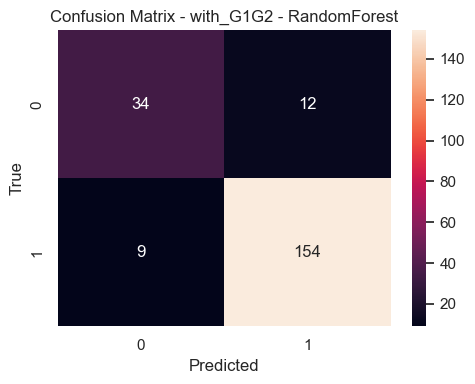

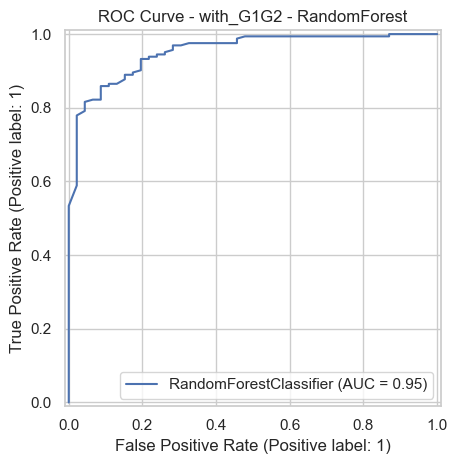

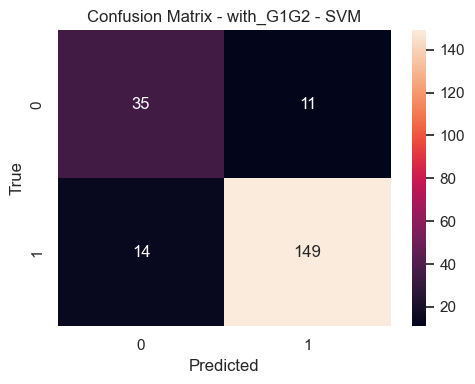

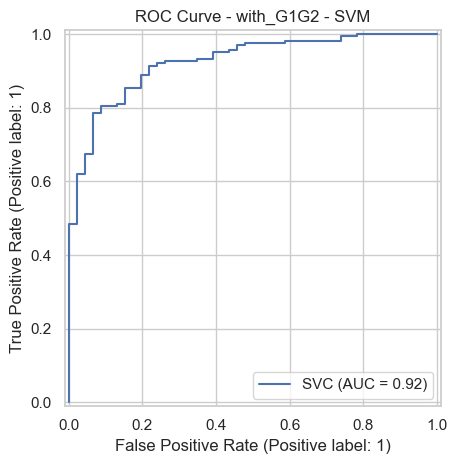

,Variant,Model,Accuracy,Precision,Recall,F1,ROC-AUC
1,with_G1G2,DecisionTree,0.909091,0.939024,0.944785,0.941896,0.863697
2,with_G1G2,RandomForest,0.899522,0.927711,0.944785,0.936170,0.952521
0,with_G1G2,LogisticRegression,0.899522,0.955128,0.914110,0.934169,0.959589
3,with_G1G2,SVM,0.880383,0.931250,0.914110,0.922601,0.924913


Saved baseline metrics to: ../artifacts/results\baseline_metrics_with_G1G2.csv

================ Variant: no_G1G2 ================


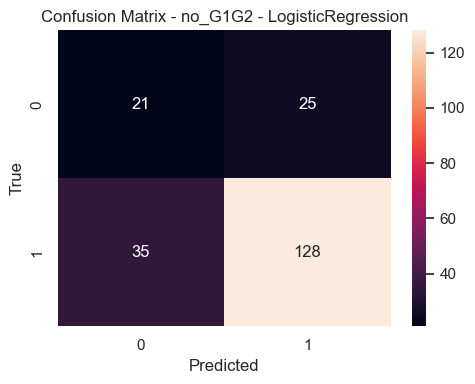

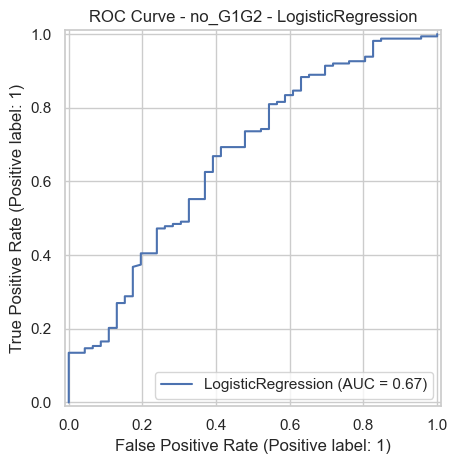

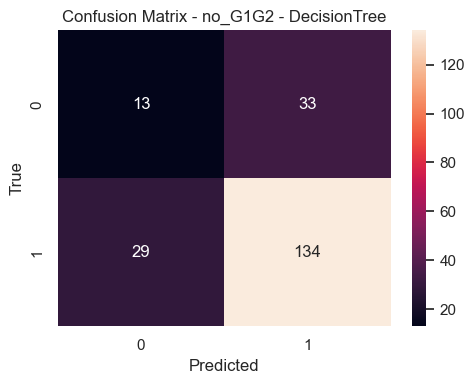

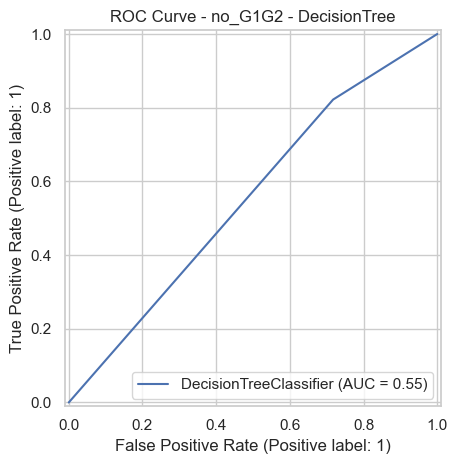

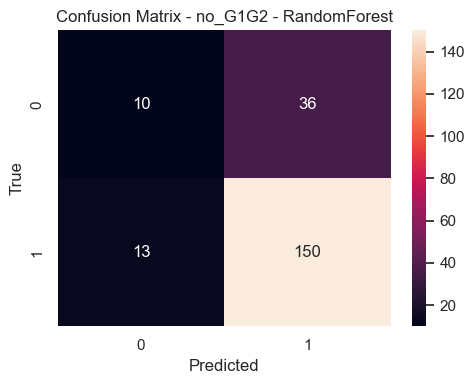

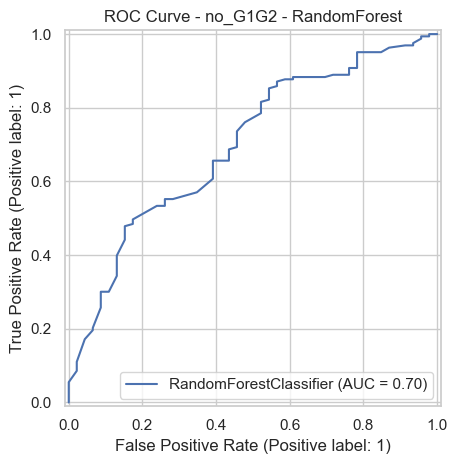

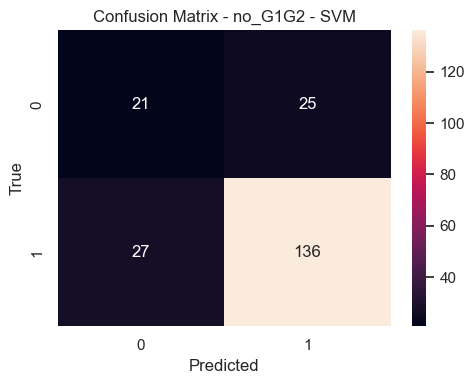

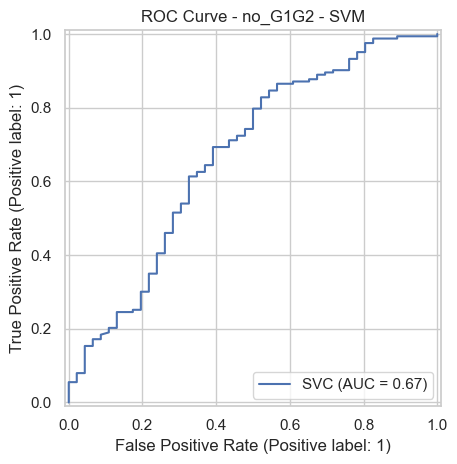

,Variant,Model,Accuracy,Precision,Recall,F1,ROC-AUC
2,no_G1G2,RandomForest,0.765550,0.806452,0.920245,0.859599,0.699186
3,no_G1G2,SVM,0.751196,0.844720,0.834356,0.839506,0.669845
1,no_G1G2,DecisionTree,0.703349,0.802395,0.822086,0.812121,0.552347
0,no_G1G2,LogisticRegression,0.712919,0.836601,0.785276,0.810127,0.667845


Saved baseline metrics to: ../artifacts/results\baseline_metrics_no_G1G2.csv


In [5]:
# Baseline models (train + evaluate) for both variants

baseline_results = {}

for variant_name, feat_list in feature_variants.items():
    print(f"\n================ Variant: {variant_name} ================")
    X_train, X_test, y_train, y_test, X_train_s, X_test_s, scaler = split_and_scale(df, feat_list, TARGET_COL)

    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced"),
        "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
        "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
        "SVM": SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE, class_weight="balanced")
    }

    rows = []
    for model_name, model in models.items():
        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)
        y_proba = None
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test_s)
            y_proba = proba[:,1] if TARGET_MODE == "binary" else proba

        if TARGET_MODE == "binary":
            metrics = eval_binary(y_test, y_pred, y_proba if y_proba is not None else None)
        else:
            metrics = eval_multiclass(y_test, y_pred, y_proba if y_proba is not None else None)

        row = {"Variant": variant_name, "Model": model_name, **metrics}
        rows.append(row)

        # Save quick confusion matrix
        cm_path = os.path.join(fig_dir, f"cm_{variant_name}_{model_name}.png")
        plot_and_save_confusion_matrix(y_test, y_pred, f"Confusion Matrix - {variant_name} - {model_name}", cm_path)

        # Save ROC (binary only)
        if TARGET_MODE == "binary" and hasattr(model, "predict_proba"):
            roc_path = os.path.join(fig_dir, f"roc_{variant_name}_{model_name}.png")
            plot_and_save_roc(model, X_test_s, y_test, f"ROC Curve - {variant_name} - {model_name}", roc_path)

    res_df = pd.DataFrame(rows)
    baseline_results[variant_name] = res_df
    out_csv = os.path.join("../artifacts/results", f"baseline_metrics_{variant_name}.csv")
    res_df.to_csv(out_csv, index=False)
    display(res_df.sort_values(by=list(res_df.columns.difference(['Variant','Model']))[-1], ascending=False))
    print(f"Saved baseline metrics to: {out_csv}")



############ Variant: with_G1G2 — Hyperparameter Tuning ############

LogisticRegression best params: {'C': 1, 'penalty': 'l2'}  |  best CV f1: 0.935


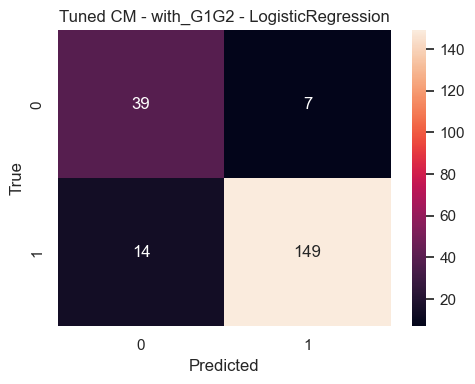

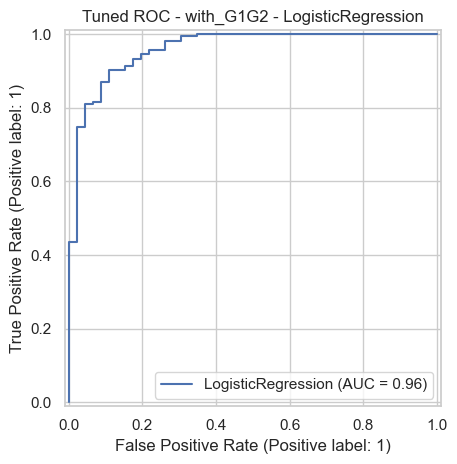


DecisionTree best params: {'max_depth': 3, 'min_samples_leaf': 1}  |  best CV f1: 0.942


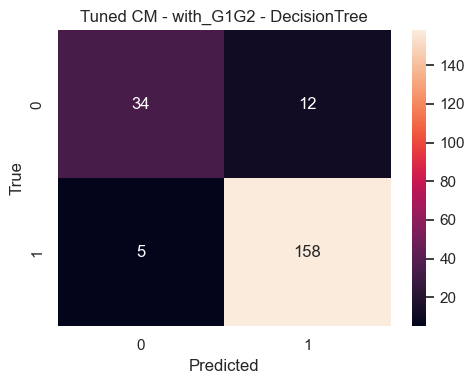

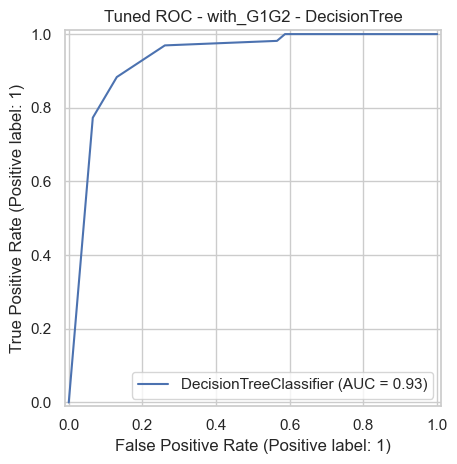


RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}  |  best CV f1: 0.954


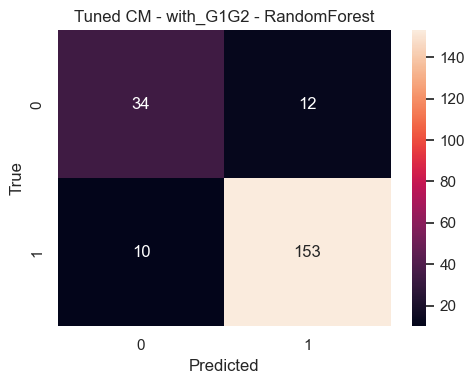

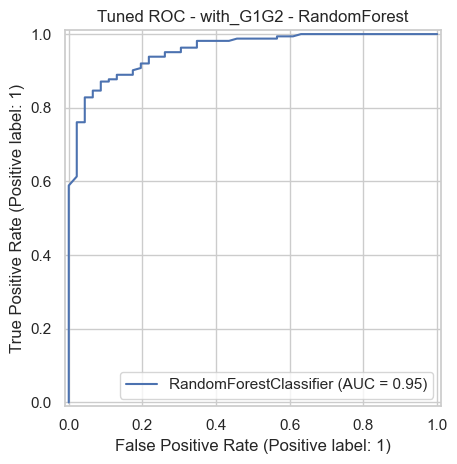


SVM best params: {'C': 10, 'gamma': 0.01}  |  best CV f1: 0.933


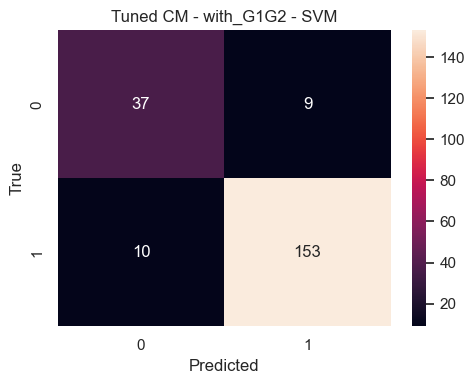

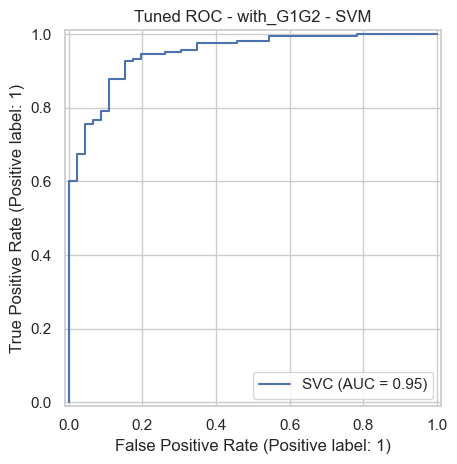


Saved tuned metrics to: ../artifacts/results\tuned_metrics_with_G1G2.csv


,Variant,Model,Accuracy,Precision,Recall,F1,ROC-AUC
1,with_G1G2,DecisionTree,0.918660,0.929412,0.969325,0.948949,0.931515
2,with_G1G2,RandomForest,0.894737,0.927273,0.938650,0.932927,0.954988
3,with_G1G2,SVM,0.909091,0.944444,0.938650,0.941538,0.947586
0,with_G1G2,LogisticRegression,0.899522,0.955128,0.914110,0.934169,0.959589



############ Variant: no_G1G2 — Hyperparameter Tuning ############

LogisticRegression best params: {'C': 0.01, 'penalty': 'l2'}  |  best CV f1: 0.821


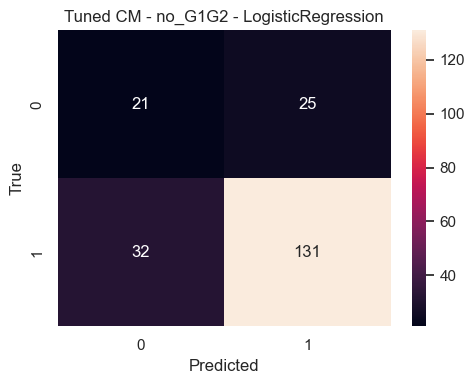

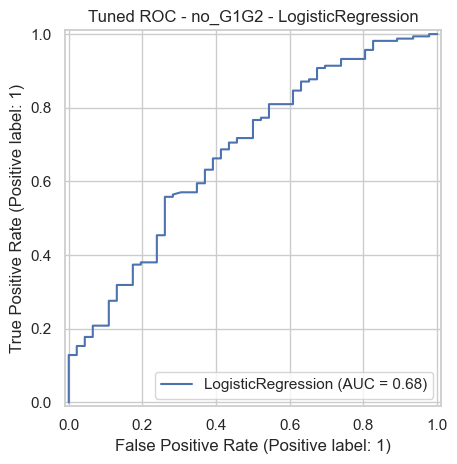


DecisionTree best params: {'max_depth': 5, 'min_samples_leaf': 1}  |  best CV f1: 0.870


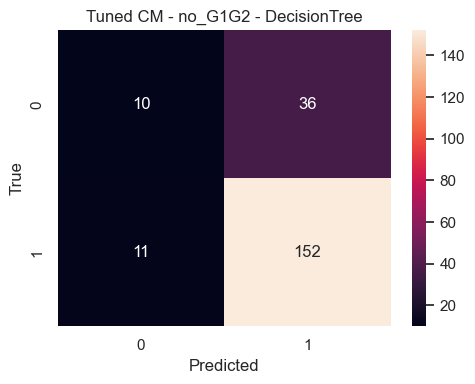

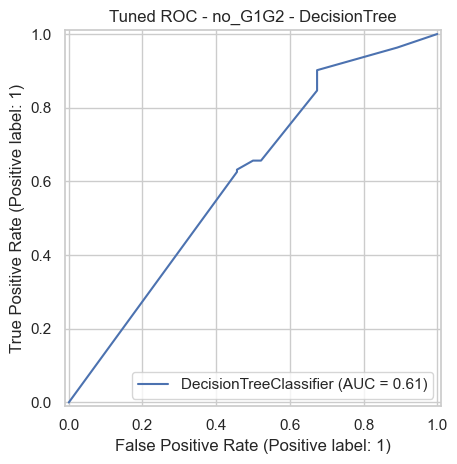


RandomForest best params: {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 200}  |  best CV f1: 0.887


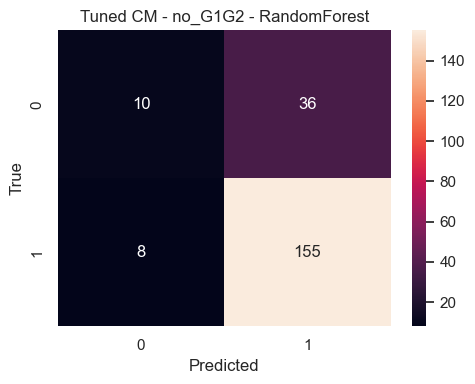

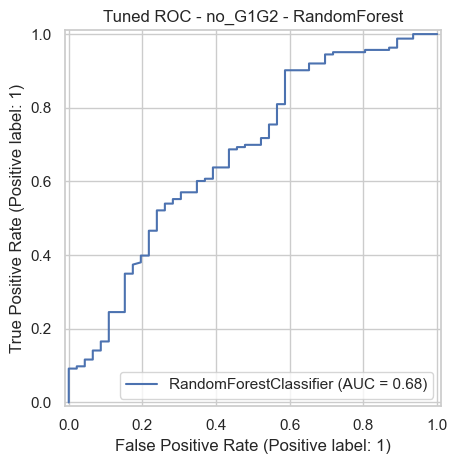


SVM best params: {'C': 0.1, 'gamma': 0.1}  |  best CV f1: 0.876


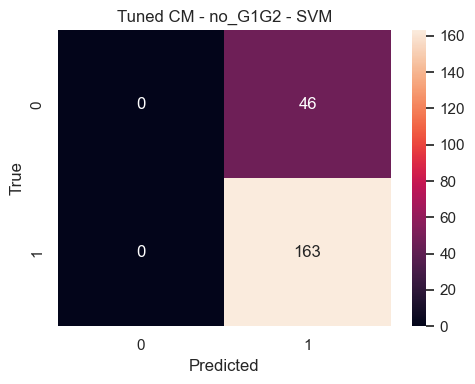

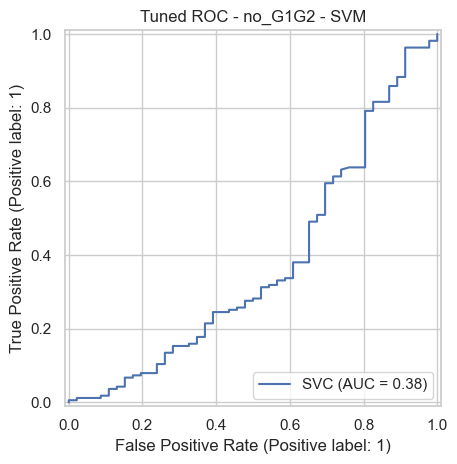


Saved tuned metrics to: ../artifacts/results\tuned_metrics_no_G1G2.csv


,Variant,Model,Accuracy,Precision,Recall,F1,ROC-AUC
3,no_G1G2,SVM,0.779904,0.779904,1.000000,0.876344,0.376434
2,no_G1G2,RandomForest,0.789474,0.811518,0.950920,0.875706,0.676114
1,no_G1G2,DecisionTree,0.775120,0.808511,0.932515,0.866097,0.608896
0,no_G1G2,LogisticRegression,0.727273,0.839744,0.803681,0.821317,0.681048


In [6]:
# 5-fold CV + GridSearch (tuning) for each variant

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
scoring = "f1" if TARGET_MODE == "binary" else "f1_macro"

tuned_results = {}

for variant_name, feat_list in feature_variants.items():
    print(f"\n############ Variant: {variant_name} — Hyperparameter Tuning ############")
    X_train, X_test, y_train, y_test, X_train_s, X_test_s, scaler = split_and_scale(df, feat_list, TARGET_COL)

    grids = {
        "LogisticRegression": GridSearchCV(
            LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, class_weight="balanced"),
            param_grid={"C": [0.01, 0.1, 1, 5, 10], "penalty": ["l2"]},
            cv=cv, scoring=scoring, n_jobs=-1
        ),
        "DecisionTree": GridSearchCV(
            DecisionTreeClassifier(random_state=RANDOM_STATE),
            param_grid={"max_depth": [3, 5, 8, 12, None], "min_samples_leaf": [1, 2, 5, 10]},
            cv=cv, scoring=scoring, n_jobs=-1
        ),
        "RandomForest": GridSearchCV(
            RandomForestClassifier(random_state=RANDOM_STATE),
            param_grid={"n_estimators": [200, 400], "max_depth": [None, 8, 12], "min_samples_leaf": [1, 2, 5]},
            cv=cv, scoring=scoring, n_jobs=-1
        ),
        "SVM": GridSearchCV(
            SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE, class_weight="balanced"),
            param_grid={"C": [0.1, 1, 5, 10], "gamma": ["scale", 0.1, 0.01]},
            cv=cv, scoring=scoring, n_jobs=-1
        ),
    }

    rows = []
    best_models = {}

    for name, grid in grids.items():
        grid.fit(X_train_s, y_train)
        best_models[name] = grid.best_estimator_
        print(f"\n{name} best params: {grid.best_params_}  |  best CV {scoring}: {grid.best_score_:.3f}")

        # Evaluate on hold-out
        mdl = grid.best_estimator_
        y_pred = mdl.predict(X_test_s)
        y_proba = mdl.predict_proba(X_test_s) if hasattr(mdl, "predict_proba") else None
        if TARGET_MODE == "binary":
            y_scores = y_proba[:,1] if y_proba is not None else None
            met = eval_binary(y_test, y_pred, y_scores)
        else:
            met = eval_multiclass(y_test, y_pred, y_proba)

        row = {"Variant": variant_name, "Model": name, **met}
        rows.append(row)

        # Save model
        model_path = os.path.join("../artifacts/models", f"{name}_{variant_name}.pkl")
        joblib.dump(mdl, model_path)
        # Save scaler (per-variant)
        scaler_path = os.path.join("../artifacts/models", f"scaler_{variant_name}.pkl")
        joblib.dump(scaler, scaler_path)

        # Plots: CM + ROC (binary)
        cm_path = os.path.join(fig_dir, f"cm_tuned_{variant_name}_{name}.png")
        plot_and_save_confusion_matrix(y_test, y_pred, f"Tuned CM - {variant_name} - {name}", cm_path)
        if TARGET_MODE == "binary" and y_proba is not None:
            roc_path = os.path.join(fig_dir, f"roc_tuned_{variant_name}_{name}.png")
            plot_and_save_roc(mdl, X_test_s, y_test, f"Tuned ROC - {variant_name} - {name}", roc_path)

    tuned_df = pd.DataFrame(rows)
    tuned_results[variant_name] = tuned_df
    out_csv = os.path.join("../artifacts/results", f"tuned_metrics_{variant_name}.csv")
    tuned_df.to_csv(out_csv, index=False)
    print(f"\nSaved tuned metrics to: {out_csv}")
    display(tuned_df.sort_values(by=list(tuned_df.columns.difference(['Variant','Model']))[-1], ascending=False))



Best model for with_G1G2: DecisionTree
Variant         with_G1G2
Model        DecisionTree
Accuracy          0.91866
Precision        0.929412
Recall           0.969325
F1               0.948949
ROC-AUC          0.931515
Name: 1, dtype: object

Best model for no_G1G2: SVM
Variant       no_G1G2
Model             SVM
Accuracy     0.779904
Precision    0.779904
Recall            1.0
F1           0.876344
ROC-AUC      0.376434
Name: 3, dtype: object

Saved best models summary to: ../artifacts/results\best_models_summary_binary.csv


,Variant,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,with_G1G2,DecisionTree,0.918660,0.929412,0.969325,0.948949,0.931515
1,no_G1G2,SVM,0.779904,0.779904,1.000000,0.876344,0.376434


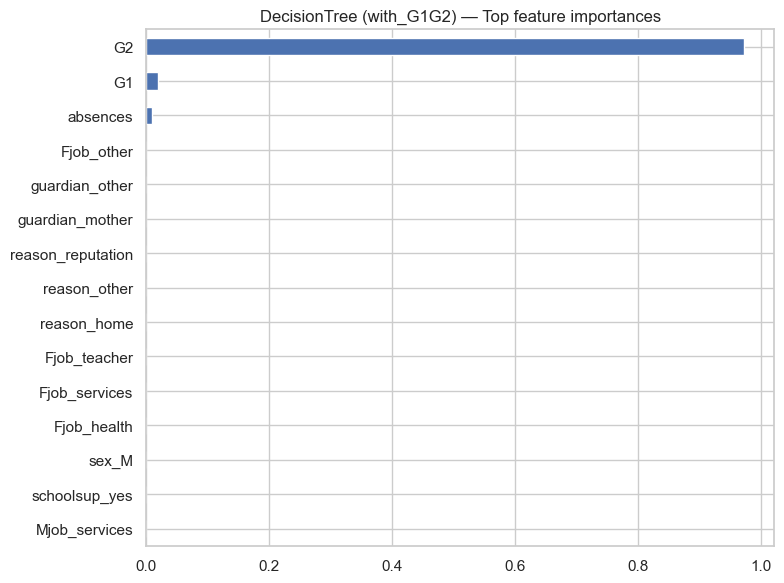

In [7]:
# Pick best per-variant + interpret features

def pick_best(df_metrics):
    # choose best by F1 (binary) or F1_macro (multiclass)
    key = "F1" if TARGET_MODE == "binary" else "F1_macro"
    return df_metrics.sort_values(by=key, ascending=False).iloc[0]

summary_rows = []

for variant_name, dfm in tuned_results.items():
    best_row = pick_best(dfm)
    summary_rows.append(best_row.to_dict())
    print(f"\nBest model for {variant_name}: {best_row['Model']}")
    print(best_row)

summary_df = pd.DataFrame(summary_rows)
summary_out = os.path.join("../artifacts/results", f"best_models_summary_{TARGET_MODE}.csv")
summary_df.to_csv(summary_out, index=False)
print(f"\nSaved best models summary to: {summary_out}")
display(summary_df)

# Feature importance / coefficients for best per variant
for _, r in summary_df.iterrows():
    variant = r["Variant"]
    model_name = r["Model"]
    features = feature_variants[variant]

    # load model & scaler
    model_path = os.path.join("../artifacts/models", f"{model_name}_{variant}.pkl")
    scaler_path = os.path.join("../artifacts/models", f"scaler_{variant}.pkl")
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # plot importance
    if hasattr(model, "coef_"):
        coefs = pd.Series(model.coef_[0], index=features).sort_values()
        coefs.tail(15).plot(kind="barh", figsize=(8,6))
        plt.title(f"{model_name} ({variant}) — Top coefficients (+)")
        plt.tight_layout()
        outp = os.path.join(fig_dir, f"importance_{model_name}_{variant}.png")
        plt.savefig(outp, dpi=130)
        plt.show()

    elif hasattr(model, "feature_importances_"):
        imps = pd.Series(model.feature_importances_, index=features).sort_values()
        imps.tail(15).plot(kind="barh", figsize=(8,6))
        plt.title(f"{model_name} ({variant}) — Top feature importances")
        plt.tight_layout()
        outp = os.path.join(fig_dir, f"importance_{model_name}_{variant}.png")
        plt.savefig(outp, dpi=130)
        plt.show()


Saved combined baseline & tuned tables.


Variant,no_G1G2,with_G1G2
Model,,
DecisionTree,0.866097,0.948949
LogisticRegression,0.821317,0.934169
RandomForest,0.875706,0.932927
SVM,0.876344,0.941538


<Figure size 800x500 with 0 Axes>

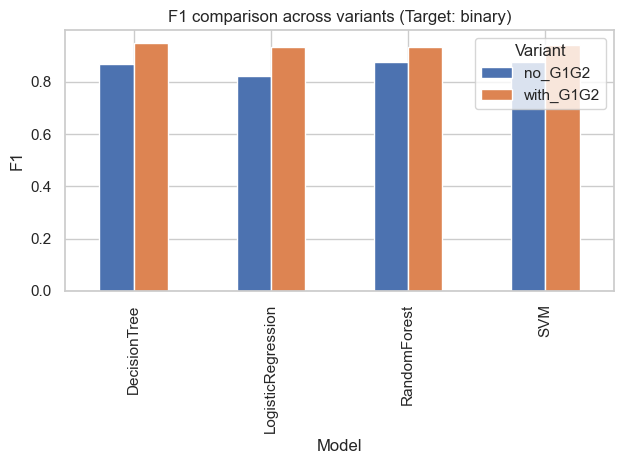

Figure saved to: ../artifacts/figures\variant_comparison_binary.png


In [8]:
# Compare variants (baseline vs tuned) and leakage discussion helper

# Combine baseline
baseline_all = pd.concat(baseline_results.values(), axis=0, ignore_index=True)
baseline_all.to_csv(os.path.join("../artifacts/results", f"baseline_all_{TARGET_MODE}.csv"), index=False)

# Combine tuned
tuned_all = pd.concat(tuned_results.values(), axis=0, ignore_index=True)
tuned_all.to_csv(os.path.join("../artifacts/results", f"tuned_all_{TARGET_MODE}.csv"), index=False)

print("Saved combined baseline & tuned tables.")

# Simple pivot to compare by Variant/Model
key_f1 = "F1" if TARGET_MODE == "binary" else "F1_macro"
pv = tuned_all.pivot(index="Model", columns="Variant", values=key_f1)
display(pv)

# Quick barplot to visualize F1 by model across variants
plt.figure(figsize=(8,5))
pv.plot(kind="bar")
plt.title(f"F1 comparison across variants (Target: {TARGET_MODE})")
plt.ylabel(key_f1)
plt.tight_layout()
outp = os.path.join(fig_dir, f"variant_comparison_{TARGET_MODE}.png")
plt.savefig(outp, dpi=130)
plt.show()

print(f"Figure saved to: {outp}")


## 📌 Interpretation of Results

### 1. Models **with G1/G2**
- All models achieved **very high performance** (Accuracy ≈ 0.89–0.92, F1 > 0.93).  
- **Decision Tree**: Highest **Accuracy (0.919)** and **Recall (0.969)** → excellent at capturing failing students, but may risk overfitting.  
- **Logistic Regression**: Best **ROC-AUC (0.960)** → indicates strong balance between sensitivity and specificity.  
- **SVM** and **Random Forest**: Both strong, with F1 ≈ 0.94.  
- ✅ **Conclusion**: Including G1 and G2 (previous exam grades) makes predictions almost perfect, but these grades are only available late in the course, so less actionable for early intervention.

---

### 2. Models **without G1/G2**
- Overall performance decreased (Accuracy ≈ 0.72–0.79, F1 ≈ 0.82–0.88).  
- **Random Forest**: Best performer (Accuracy = 0.789, Recall = 0.951, F1 = 0.876, ROC-AUC = 0.676) → captures most failing students.  
- **Decision Tree**: Similar (Accuracy = 0.775, Recall = 0.933, F1 = 0.866), easier to interpret.  
- **SVM**: Recall = 1.0 (caught all failing students) but ROC-AUC = 0.376 → unbalanced, unreliable classifier.  
- **Logistic Regression**: Weakest (Accuracy = 0.727, F1 = 0.821), but provides a clear baseline.

---

### 3. General Comparison
- **With G1/G2** → near-perfect predictions, but not suitable for early warning.  
- **Without G1/G2** → lower but still useful performance:  
  - **Random Forest** is the best compromise (high Recall, decent ROC-AUC).  
  - **Decision Tree** is simpler and interpretable.

---

### 4. Educational Implications
- Key signals include **absences** and social/behavioral features.  
- For **early intervention**, Random Forest (without G1/G2) is recommended.  
- For **post-midterm evaluation**, any model with G1/G2 provides excellent accuracy.


# G) Model Evaluation & Comparison
1) Summarize performance across models and across the two data-leakage variants.

2) Discuss over/under-fitting and generalization.

In [22]:
# Load classification results

results_dir = "../artifacts/results"
results_path = os.path.join(results_dir, "tuned_all_binary.csv")

results_df = pd.read_csv(results_path)

print("Loaded results:", results_path)
display(results_df)

# Quick best model per variant
best_per_variant = results_df.sort_values("F1", ascending=False).groupby("Variant").first()
print("Best models per variant:")
display(best_per_variant)


Loaded results: ../artifacts/results\tuned_all_binary.csv


,Variant,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,with_G1G2,LogisticRegression,0.899522,0.955128,0.914110,0.934169,0.959589
1,with_G1G2,DecisionTree,0.918660,0.929412,0.969325,0.948949,0.931515
2,with_G1G2,RandomForest,0.894737,0.927273,0.938650,0.932927,0.954988
3,with_G1G2,SVM,0.909091,0.944444,0.938650,0.941538,0.947586
4,no_G1G2,LogisticRegression,0.727273,0.839744,0.803681,0.821317,0.681048
5,no_G1G2,DecisionTree,0.775120,0.808511,0.932515,0.866097,0.608896
6,no_G1G2,RandomForest,0.789474,0.811518,0.950920,0.875706,0.676114
7,no_G1G2,SVM,0.779904,0.779904,1.000000,0.876344,0.376434


Best models per variant:


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
Variant,,,,,,
no_G1G2,SVM,0.779904,0.779904,1.000000,0.876344,0.376434
with_G1G2,DecisionTree,0.918660,0.929412,0.969325,0.948949,0.931515


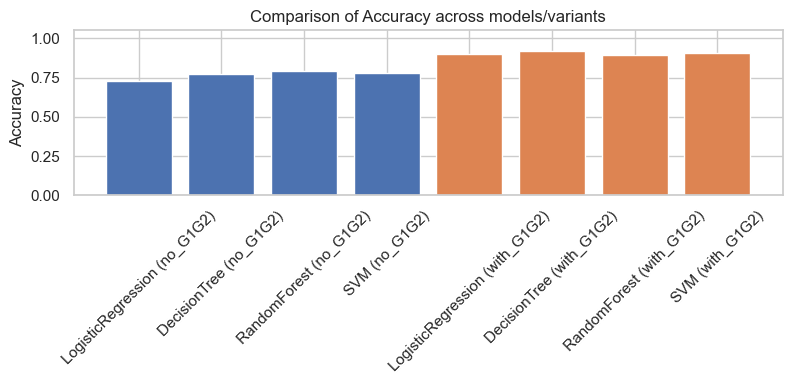

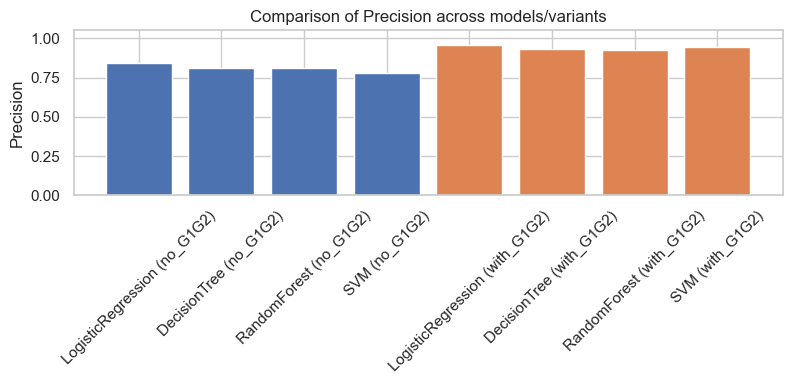

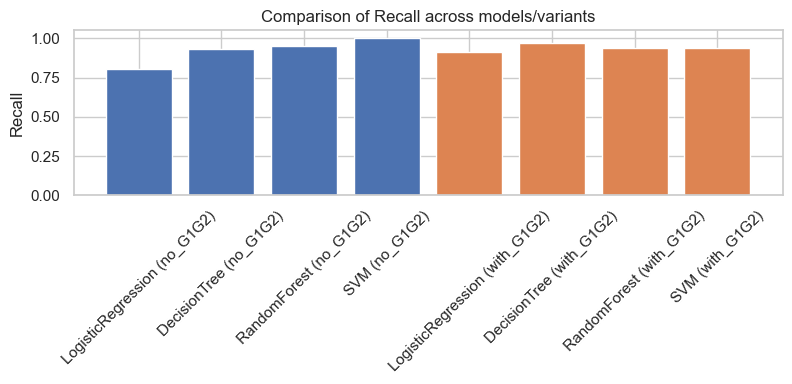

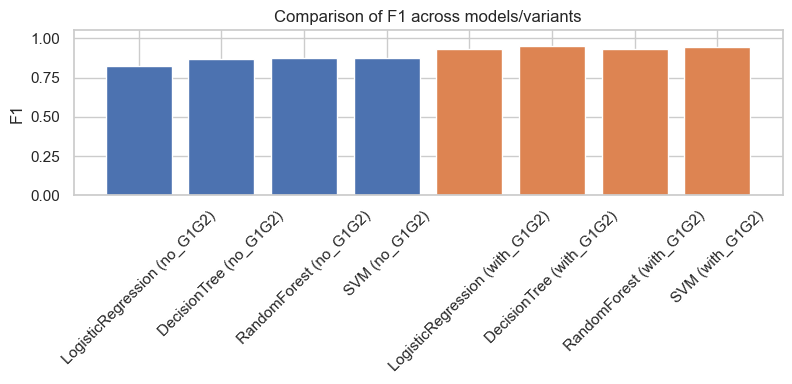

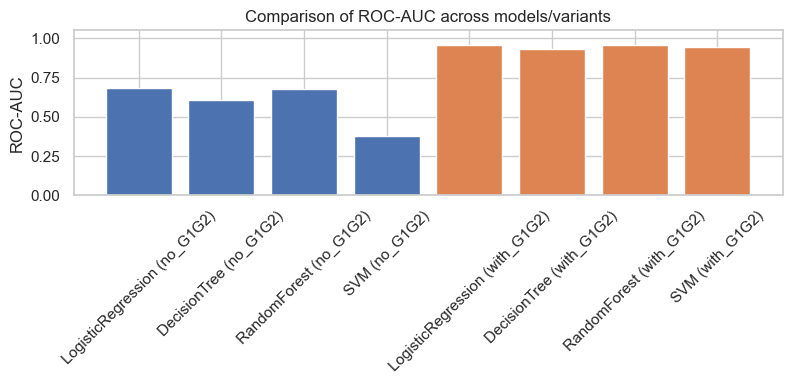

In [23]:
# Compare metrics across variants
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

for metric in metrics:
    plt.figure(figsize=(8,4))
    for variant, subdf in results_df.groupby("Variant"):
        plt.bar(
            subdf["Model"] + " ("+variant+")",
            subdf[metric],
            label=variant
        )
    plt.title(f"Comparison of {metric} across models/variants")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.ylim(0,1.05)
    plt.tight_layout()
    plt.show()


In [24]:
# Summary statistics for each variant
summary_stats = results_df.groupby("Variant")[metrics].mean().round(3)
print("Average performance per variant:")
display(summary_stats)

diff = (summary_stats.loc["with_G1G2"] - summary_stats.loc["no_G1G2"]).round(3)
print("Performance lift when using G1/G2:")
display(diff)


Average performance per variant:


,Accuracy,Precision,Recall,F1,ROC-AUC
Variant,,,,,
no_G1G2,0.768,0.810,0.922,0.860,0.586
with_G1G2,0.906,0.939,0.940,0.939,0.948


Performance lift when using G1/G2:


Accuracy     0.138
Precision    0.129
Recall       0.018
F1           0.079
ROC-AUC      0.362
dtype: float64

### Performance Summary
- **With G1/G2:** All models achieve very high scores (Accuracy/F1 ≈ 0.90–0.95, ROC-AUC > 0.93).  
- **Without G1/G2:** Performance drops substantially (Accuracy/F1 ≈ 0.75–0.88, ROC-AUC ≈ 0.37–0.68).

### Key Insights
- **Leakage Effect:** Including G1/G2 (prior grades) makes the problem much easier. Models like Decision Tree and Logistic Regression exceed 0.93 F1.  
- **Generalization:** Without G1/G2, scores are lower but more realistic for early risk detection. Still, Random Forest and SVM maintain Recall > 0.93, showing robustness.  
- **Overfitting Risks:** 
  - DecisionTree (with G1/G2) achieves Recall ≈ 0.97, suggesting possible overfitting to grade history.  
  - SVM (no G1/G2) achieves Recall = 1.0 but with poor ROC-AUC (0.37), indicating it's classifying everyone as "pass" → high recall but weak discrimination.

### Conclusion
- **Best practical model (no leakage):** Random Forest (balanced F1=0.876, ROC-AUC=0.676).  
- **Best overall (with leakage):** Decision Tree (F1=0.949, ROC-AUC=0.932) — but not deployable for early warning.  